<a href="https://colab.research.google.com/github/jayanth142006/potato-disease-classification-models/blob/main/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

train_path = '/content/drive/MyDrive/potato_dis_aug'

# Get all class folders
class_names = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Dictionary to store image counts
class_image_counts = {}

# Count images in each class folder
for cls in class_names:
    class_folder = os.path.join(train_path, cls)
    image_files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
    class_image_counts[cls] = len(image_files)

# Display results
print(f"Total classes: {len(class_names)}\n")
for cls, count in class_image_counts.items():
    print(f"{cls}: {count} images")


Total classes: 7

Pest: 1205 images
Phytopthora: 691 images
Virus: 1070 images
Bacteria: 1124 images
Fungi: 1471 images
Nematode: 667 images
Healthy: 593 images


In [ ]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define input and output directories
input_dir = "/content/drive/MyDrive/potato_dis"
output_dir = "/content/drive/MyDrive/potato_dis_aug"
os.makedirs(output_dir, exist_ok=True)

# Augmentation strategy per class
augmentation_map = {
    "Pest": 1,
    "Phytopthora": 1,
    "Virus": 1,
    "Bacteria": 1,
    "Fungi": 1,
    "Nematode": 9,
    "Healthy": 2
}

# ImageDataGenerator settings
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

print("[INFO] Starting augmentation process...")

# Loop through each class
for class_name, aug_count in augmentation_map.items():
    print(f"[INFO] Processing class '{class_name}' with {aug_count} augmentations per image")

    input_class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    # Filter image files
    image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

    for img_name in image_files:
        img_path = os.path.join(input_class_dir, img_name)

        # Copy original image
        shutil.copy(img_path, os.path.join(output_class_dir, img_name))

        # Prepare for augmentation
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        gen = aug.flow(img_array, batch_size=1,
                       save_to_dir=output_class_dir,
                       save_prefix="aug",
                       save_format="jpg")

        # Save augmentations
        total = 0
        for _ in gen:
            total += 1
            if total >= aug_count:
                break

print("[INFO] ✅ All images and augmentations saved successfully.")


[INFO] Starting augmentation process...
[INFO] Processing class 'Pest' with 1 augmentations per image
[INFO] Processing class 'Phytopthora' with 1 augmentations per image
[INFO] Processing class 'Virus' with 1 augmentations per image
[INFO] Processing class 'Bacteria' with 1 augmentations per image
[INFO] Processing class 'Fungi' with 1 augmentations per image
[INFO] Processing class 'Nematode' with 9 augmentations per image
[INFO] Processing class 'Healthy' with 2 augmentations per image
[INFO] ✅ All images and augmentations saved successfully.


In [ ]:
train_path = '/content/drive/MyDrive/potato_dis_aug'
img_size = (224, 224)
batch_size = 32
num_classes = 7  # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5459 images belonging to 7 classes.
Found 1362 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze All Convolutional Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3195s 18s/step - accuracy: 0.2979 - loss: 1.8036 - val_accuracy: 0.5441 - val_loss: 1.1711
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 159s 932ms/step - accuracy: 0.5093 - loss: 1.2833 - val_accuracy: 0.5984 - val_loss: 1.0640
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 158s 921ms/step - accuracy: 0.5430 - loss: 1.1889 - val_accuracy: 0.6219 - val_loss: 0.9560
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 162s 948ms/step - accuracy: 0.5863 - loss: 1.1135 - val_accuracy: 0.6424 - val_loss: 0.9184
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 157s 918ms/step - accuracy: 0.6027 - loss: 1.0734 - val_accuracy: 0.6828 - val_loss: 0.8657
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 159s 929ms/step - accuracy: 0.5974 - loss: 1.0676 - val_accuracy: 0.7004 - val_loss: 0.8093
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 155s 908ms/step - accuracy: 0.6343 - loss: 0.9806 - val_accuracy: 0.7070 - val_loss: 0.7896
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 209s 950ms/step - accuracy: 0.6153 - 

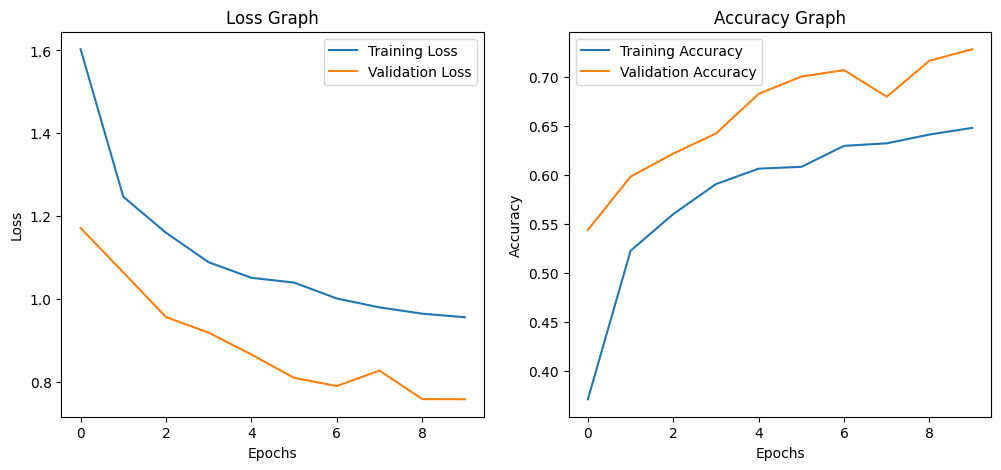

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 913ms/step
Before Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       0.97      0.81      0.88       224
       Fungi       0.63      0.66      0.64       294
     Healthy       0.56      0.72      0.63       118
    Nematode       0.92      0.95      0.93       133
        Pest       0.61      0.55      0.58       241
 Phytopthora       0.87      0.75      0.81       138
       Virus       0.70      0.79      0.74       214

    accuracy                           0.73      1362
   macro avg       0.75      0.75      0.75      1362
weighted avg       0.74      0.73      0.73      1362



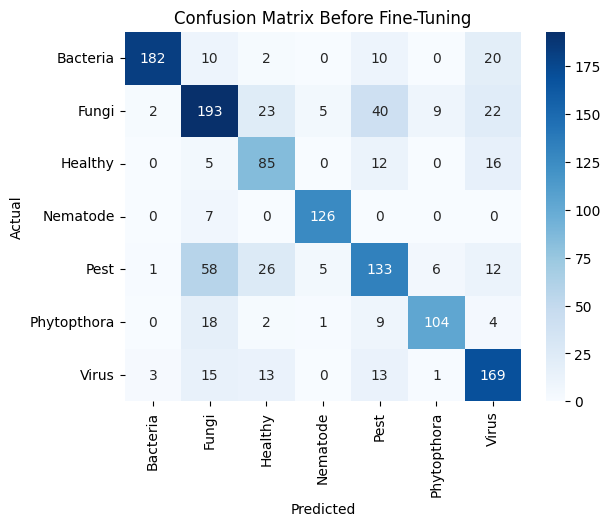

In [ ]:
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 168s 980ms/step - accuracy: 0.9163 - loss: 0.2328 - val_accuracy: 0.9214 - val_loss: 0.2117
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 160s 935ms/step - accuracy: 0.9210 - loss: 0.2506 - val_accuracy: 0.9288 - val_loss: 0.2002
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 158s 927ms/step - accuracy: 0.9315 - loss: 0.2080 - val_accuracy: 0.9156 - val_loss: 0.2220
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9288 - loss: 0.2020 - val_accuracy: 0.9317 - val_loss: 0.1904
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 166s 967ms/step - accuracy: 0.9371 - loss: 0.1836 - val_accuracy: 0.9435 - val_loss: 0.1704
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 163s 953ms/step - accuracy: 0.9454 - loss: 0.1549 - val_accuracy: 0.9325 - val_loss: 0.1804
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 160s 936ms/step - accuracy: 0.9502 - loss: 0.1596 - val_accuracy: 0.9369 - val_loss: 0.1531
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 161s 939ms/step - accuracy: 0.9533 - lo

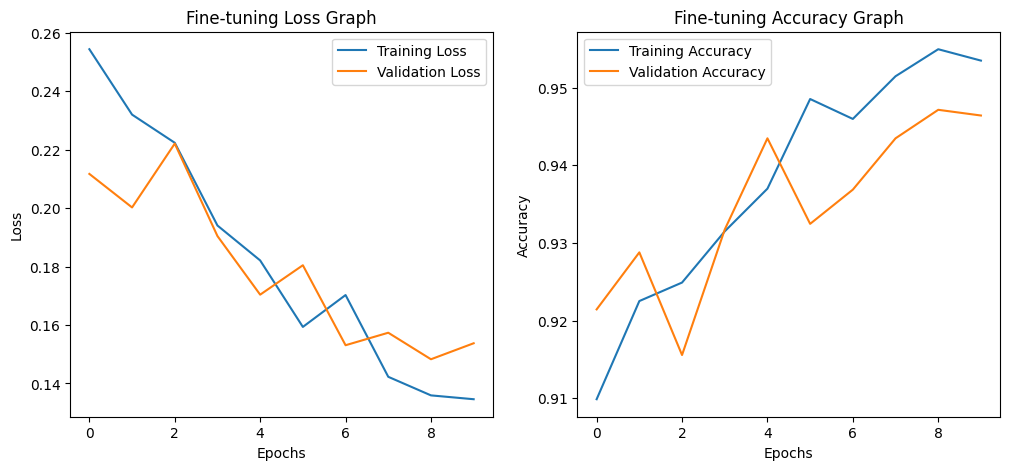

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step
After Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       1.00      0.99      0.99       224
       Fungi       0.95      0.92      0.93       294
     Healthy       0.79      1.00      0.88       118
    Nematode       1.00      0.99      1.00       133
        Pest       0.94      0.89      0.91       241
 Phytopthora       0.94      0.96      0.95       138
       Virus       0.99      0.94      0.96       214

    accuracy                           0.95      1362
   macro avg       0.94      0.96      0.95      1362
weighted avg       0.95      0.95      0.95      1362



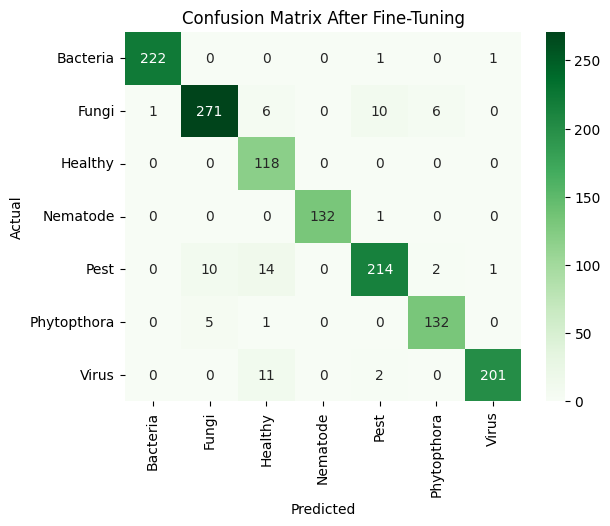

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()

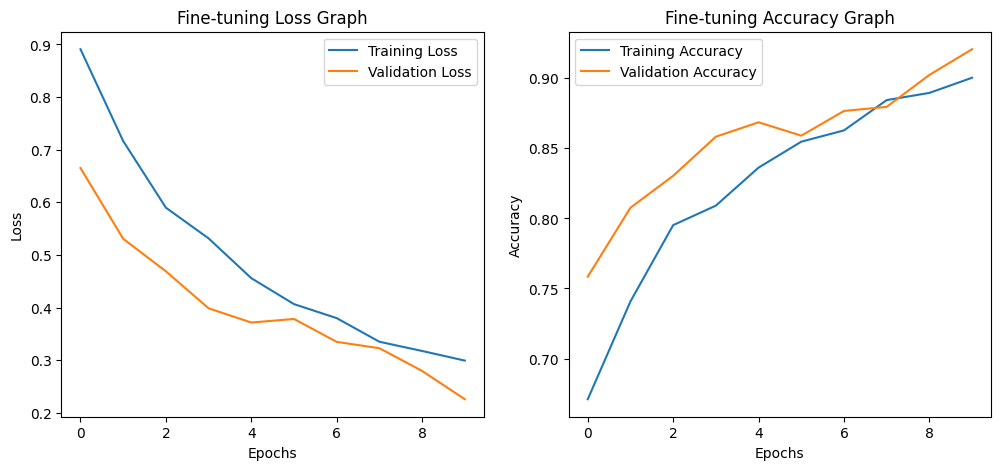

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 851ms/step
After Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       1.00      0.98      0.99       224
       Fungi       0.87      0.91      0.89       294
     Healthy       0.82      0.98      0.89       118
    Nematode       0.98      1.00      0.99       133
        Pest       0.89      0.83      0.86       241
 Phytopthora       0.93      0.92      0.93       138
       Virus       0.97      0.90      0.94       214

    accuracy                           0.92      1362
   macro avg       0.92      0.93      0.93      1362
weighted avg       0.92      0.92      0.92      1362



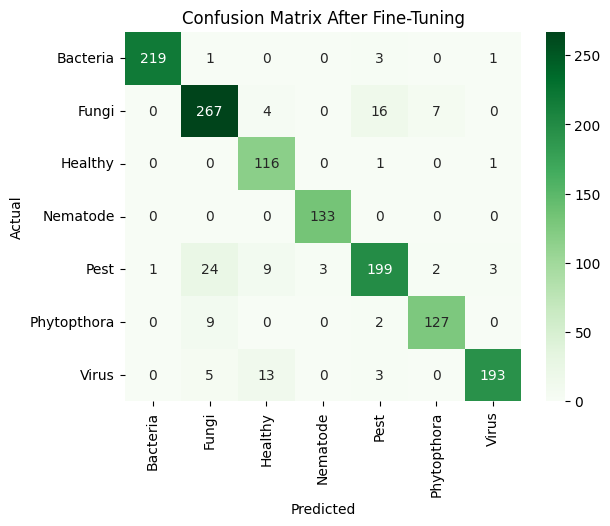

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()